In [2]:
%pip install pyts

  Using cached pyts-0.13.0-py3-none-any.whl.metadata (10 kB)
Using cached pyts-0.13.0-py3-none-any.whl (2.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
import pyts.datasets
from pyts.transformation import ShapeletTransform


In [37]:
from pyts.datasets import fetch_ucr_dataset

# Fetching a sample dataset to check
dataset = fetch_ucr_dataset("GunPoint")
print(dataset.keys())  # Display keys of the dataset to confirm

dict_keys(['data_train', 'target_train', 'data_test', 'target_test', 'DESCR', 'url'])


In [38]:
DS = 'GunPoint'
X_train, X_test, y_train, y_test = pyts.datasets.fetch_ucr_dataset(dataset=DS, return_X_y=True)
Ori_test = X_test

In [39]:
X_train.shape

(50, 150)

In [40]:
X_test.shape

(150, 150)

In [41]:
y_train

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 2], dtype=int64)

In [42]:
def label_encoder(training_labels, testing_labels):

    le = preprocessing.LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)

    return y_train, y_test

y_train, y_test = label_encoder(y_train, y_test)

In [43]:
y_train

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1], dtype=int64)

In [44]:
def get_shapelet(X_train, y_train, len_ts):
    a = int(len_ts * 0.3)
    b = int(len_ts * 0.5)
    c = int(len_ts * 0.7)
    st = ShapeletTransform(n_shapelets=100, window_sizes=[a, b, c],
                           random_state=42, sort=True)
    st.fit_transform(X_train, y_train)
    indices = pd.DataFrame(st.indices_)
    return indices

# category the shapelets by their label, res include 4 columns, the index, start index, end index, and the label
def shapelet_category(y_train, indices, label):
    labels = y_train[indices.iloc[:, 0]]
    labels = pd.DataFrame(labels)
    frames = [indices, labels]
    res = pd.concat(frames, axis=1)
    res.columns=["idx", "start_point", "end_point", "label"]
    res = res.groupby('label')
    res = res.get_group(label).head(1)
    res = np.array(res)
    return res

In [45]:
len_ts = X_train.shape[1]
classes =np.unique(y_test)
nb_classes = len(classes)
print(X_train.shape, len_ts, classes)
idx_shapelets = get_shapelet(X_train, y_train, len_ts)  # index, start_point, end_point
shapelets = []
for i in classes:
    shapelets.append(shapelet_category(y_train, idx_shapelets, i))
print(shapelets)

(50, 150) 150 [0 1]
[array([[48,  0, 75,  0]], dtype=int64), array([[34, 17, 62,  1]], dtype=int64)]


In [46]:
shapelet_dic = {}
for cls in range(nb_classes):
    shapelet_dic[cls] = X_train[shapelets[cls][0][0]][shapelets[cls][0][1]:shapelets[cls][0][2]]

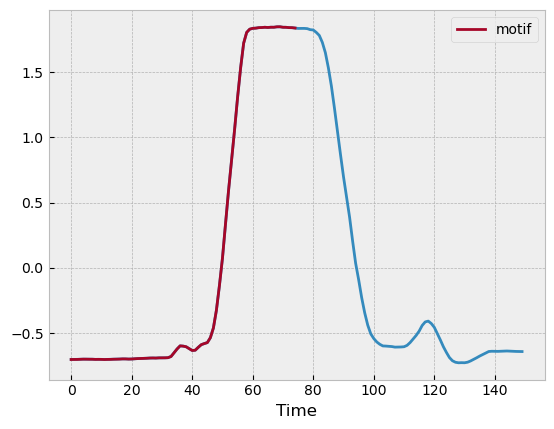

In [47]:
plt.style.use('bmh')
cls = 0
plt.plot(X_train[shapelets[cls][0][0]], )
plt.plot(np.arange(shapelets[cls][0][1], shapelets[cls][0][2]),
         X_train[shapelets[cls][0][0], shapelets[cls][0][1]:shapelets[cls][0][2]], label = "motif")


plt.xlabel('Time', fontsize=12)
# plt.title('The shapelets', fontsize=14)
plt.legend()
plt.show()

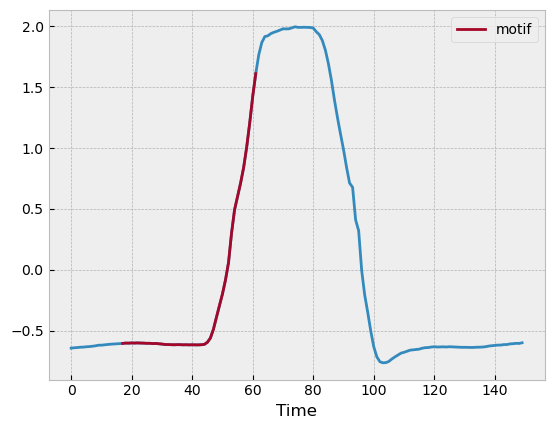

In [48]:
plt.style.use('bmh')
cls = 1
plt.plot(X_train[shapelets[cls][0][0]],)
plt.plot(np.arange(shapelets[cls][0][1], shapelets[cls][0][2]),
         X_train[shapelets[cls][0][0], shapelets[cls][0][1]:shapelets[cls][0][2]], label = "motif")

plt.xlabel('Time', fontsize=12)
plt.legend()
plt.show()


# train & test data

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

classifier = RandomForestClassifier()

def train(classifier, X_train, y_train, X_test):
  model = classifier
  model.fit(X_train, y_train)
  return model

model = train(classifier, X_train, y_train, X_test)

In [ ]:
%pip install tensorflow

## Keras Model

In [49]:
X_train.shape

(50, 150)

In [50]:
X_test.shape

(150, 150)

In [51]:
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(50, 1, 150)
(150, 1, 150)


In [52]:
import pickle
import os
import sys
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt

# Assuming X_train, y_train, X_test, y_test are already loaded from somewhere
# Replace this part with actual data loading code
# For example:
# X_train, X_test, y_train, y_test = load_your_data()

def load_data(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
    return data

def save_model(model, filepath):
    model.save(filepath)

def load_model(filepath):
    return keras.models.load_model(filepath)

def create_autoencoder(input_shape):
    # Encoder using Functional API
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=3, strides=2, padding="same", activation="relu")(input_layer)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=8, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    conv_output = x  # Save this for decoder
    x = layers.Flatten()(x)
    encoded = layers.Dense(80)(x)

    # Decoder
    x = layers.Dense(np.prod(conv_output.shape[1:]))(encoded)
    x = layers.Reshape((conv_output.shape[1], conv_output.shape[2]))(x)
    x = layers.Conv1DTranspose(filters=8, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    decoded = layers.Conv1DTranspose(filters=1, kernel_size=3, padding="same")(x)
    decoded = layers.Cropping1D(cropping=(1, 1))(decoded)

    # Autoencoder model
    autoencoder = models.Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

if __name__ == "__main__":
    # Define dataset name
    dataset = 'gunpoint'

    # Define the input shape based on X_train
    input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

    # Create and compile the Autoencoder model
    autoencoder = create_autoencoder(input_shape)
    autoencoder.summary()

    # Train AE model
    history = autoencoder.fit(
        X_train_reshaped,
        X_train_reshaped,
        epochs=20,
        batch_size=1,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )

    # Save the trained model
    model_filepath = 'autoencoder_model.h5'
    save_model(autoencoder, model_filepath)



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 16)          │         7,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1, 8)           │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 80)             │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 2, 8)           │           200 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 4, 16)          │           400 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 4, 1)           │            49 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_1 (Cropping1D)       │ (None, 2, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,625 (37.60 KB)

 Trainable params: 9,625 (37.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9936 - val_loss: 0.9933
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 - val_loss: 0.9933
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 - val_loss: 0.9933
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 - val_loss: 0.9933
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 - val_loss: 0.9933
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 - val_loss: 0.9933
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 - val_loss: 0.9933
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9933 - val_loss: 0.9933
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 - val_loss: 0.9933
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 - val_loss: 0.9933
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 - val_loss: 0.9933


In [ ]:
"""from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import numpy as np

# Define the file path for loading the model
model_filepath = 'autoencoder_model.h5'

# Load the model with custom 'mse' loss function
keras_model = keras.models.load_model(model_filepath, custom_objects={'mse': MeanSquaredError()})

# Recompile the model after loading
keras_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

# Train the model on X_train and y_train
history = keras_model.fit(
    X_train, 
    y_train,  # Assuming this is labeled data
    epochs=20, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ]
)

# After training, predict on X_test
y_pred = keras_model.predict(X_test)

# Optionally, round predictions if they are continuous values and you need classes (e.g., for classification)
y_pred_classes = np.argmax(y_pred, axis=1)  # For classification with softmax output
# Alternatively, for binary classification, you could threshold the outputs
y_pred_classes = (y_pred > 0.5).astype("int32")  # Assuming sigmoid activation for binary
print(y_pred_classes)

# Print predictions
print("Predictions on X_test:")
print(y_pred)

# Optionally, evaluate the model on the test set
test_loss, test_accuracy = keras_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")"""


In [53]:
from tensorflow.keras.optimizers import Adam

def create_classifier(base_model, num_classes):
    # Freeze the base model (encoder) weights
    base_model.trainable = False
    
    # Extract the encoder output
    x = base_model.layers[-2].output  # Modify this if your encoder output is from a different layer
    
    # Reduce dimensionality using Global Average Pooling (or Flatten)
    x = layers.GlobalAveragePooling1D()(x)  # Reduces (batch_size, timesteps, features) -> (batch_size, features)
    
    # Add new layers for classification
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)  # Output layer for classification

    # Create and compile the classifier model
    classifier_model = models.Model(inputs=base_model.input, outputs=x)
    classifier_model.compile(optimizer='adam', 
                             loss='sparse_categorical_crossentropy',  # Use this if labels are integers
                             metrics=['accuracy'])
    return classifier_model

# Number of classes (ensure y_train contains the correct label format)
num_classes = len(np.unique(y_train))

# Create the classifier model
classifier_model = create_classifier(autoencoder, num_classes)  # Use your trained autoencoder here

# Train the classifier
history_classifier = classifier_model.fit(
    X_train_reshaped, 
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ]
)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.4273 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4926 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6936
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4822 - loss: 0.6933 - val_accuracy: 0.4000 - val_loss: 0.6936
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4613 - loss: 0.6934 - val_accuracy: 0.4000 - val_loss: 0.6937
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5134 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6939
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4822 - loss: 0.6933 - val_accuracy: 0.4000 - val_loss: 0.6938


In [54]:
y_pred = classifier_model.predict(X_test_reshaped)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

print(y_pred_labels)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [55]:
# Define the functions
def target(prediction_probs):
    top_two_indices = np.argsort(prediction_probs)[-2:]
    return top_two_indices[-2]

def targets_generation(predictions):
    targets = []
    for instance_probs in predictions:
        res = target(instance_probs)
        targets.append(res)
    return targets

# Generate targets
targets = targets_generation(y_pred)

# Print the first few targets
print("Generated targets:", targets[:10])

Generated targets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [56]:
y_test

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0], dtype=int64)

In [57]:
counterfactual_examples = []
def counterfacutal_generation(test_samples):
  for i in range(len(test_samples)):
    index, start, end = shapelets[targets[i]][0][0], shapelets[targets[i]][0][1], shapelets[targets[i]][0][2]
    test_samples[i][start:end] = X_train[index][start:end]
    counterfactual_examples.append(test_samples[i])
  return counterfactual_examples


In [58]:
counterfactual_examples = counterfacutal_generation(X_test)

In [59]:
_, X_test, _, _ = pyts.datasets.fetch_ucr_dataset(dataset=DS, return_X_y=True)

In [60]:
y_test

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0], dtype=int64)

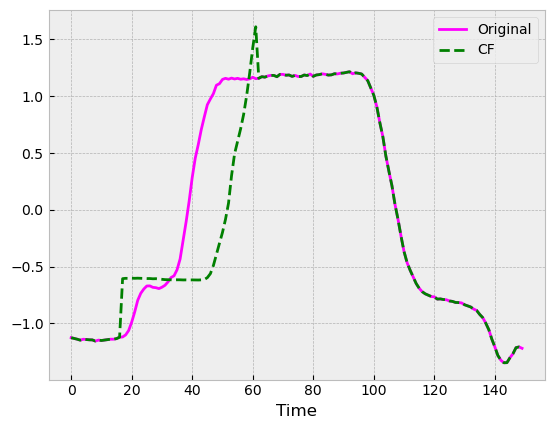

In [61]:
plt.style.use('bmh')

plt.plot(X_test[0], label = 'Original', color='magenta')
plt.plot(counterfactual_examples[0], label = 'CF', ls='--', color='green')

plt.xlabel('Time', fontsize=12)
# plt.title('The shapelets', fontsize=14)
plt.legend()
plt.show()

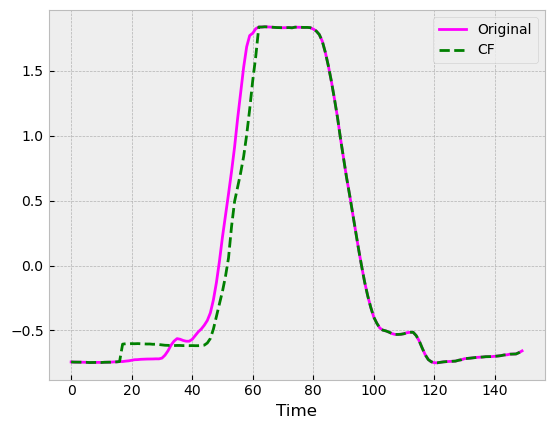

In [62]:
plt.style.use('bmh')

plt.plot(X_test[4], label = 'Original', color='magenta')
plt.plot(counterfactual_examples[4], label = 'CF', ls='--', color='green')

plt.xlabel('Time', fontsize=12)
# plt.title('The shapelets', fontsize=14)
plt.legend()
plt.show()

In [63]:
from scipy.spatial import distance
import numpy as np

def getmetrics(x1, x2):
    # Convert lists to NumPy arrays
    x1 = np.array(x1)
    x2 = np.array(x2)

    # Compute the difference and metrics
    diff = np.round(x1 - x2, 3)
    l1 = distance.cityblock(x1, x2)
    l2 = np.linalg.norm(x1 - x2)  # Euclidean distance (L2 norm)
    l_inf = distance.chebyshev(x1, x2)  # Chebyshev distance (L∞ norm)
    dist = distance.cityblock(x1, x2)
    sparsity = (len(diff) - np.count_nonzero(diff)) / len(diff)

    # Compute the number of segments with non-zero values
    segnums = get_segmentsNumber(diff)

    return l1, l2, l_inf, dist, sparsity, segnums

def get_segmentsNumber(l4):
    flag, count = 0, 0
    for i in range(len(l4)):
        if l4[i] != 0:
            flag = 1
        if flag == 1 and l4[i] == 0:
            count += 1
            flag = 0
    return count

In [64]:
print(np.array(counterfactual_examples).shape)

counterfactual_examples = np.array(counterfactual_examples)
counterfactual_examples = counterfactual_examples.reshape((-1, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

counter_res = classifier_model.predict(counterfactual_examples)

(150, 150)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [65]:
target_probs = []
for i in range(len(counter_res)):
  target_prob = counter_res[i][targets[i]]
  target_probs.append(target_prob)

In [67]:
import numpy as np
import pandas as pd
from scipy.spatial import distance

# Ensure that X_test and counterfactual_examples are NumPy arrays and have the correct shape
X_test = np.array(X_test)
counterfactual_examples = np.array(counterfactual_examples)

# Flatten arrays if they are multidimensional
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
counterfactual_examples_flattened = counterfactual_examples.reshape(counterfactual_examples.shape[0], -1)

# Compute target probabilities (ensure this is correctly assigned before this point)
# target_probs should have the same length as X_test
assert len(target_probs) == len(X_test), "target_probs length must match X_test length"

res = []

# Loop through test samples
for i in range(len(X_test)):
    # Compute metrics for each pair
    l1, l2, l_inf, dist, sparsity, segnums = getmetrics(
        X_test_flattened[i], 
        counterfactual_examples_flattened[i]
    )
    
    # Append metrics and target probabilities to the results list
    res.append([l1, l2, l_inf, dist, sparsity, segnums, target_probs[i]])

# Convert the results list to a DataFrame
res_df = pd.DataFrame(res, columns=['l1', 'l2', 'l_inf', 'dist', 'sparsity', 'segnums', 'target_probs'])

# Print the DataFrame to check
print(res_df.head())


          l1        l2     l_inf       dist  sparsity  segnums  target_probs
0  25.756286  5.187624  1.537324  25.756286       0.7        1      0.498340
1   1.553516  0.331605  0.211467   1.553516       0.7        1      0.498356
2  40.848429  6.724388  1.399894  40.848429       0.7        1      0.498328
3  16.118093  3.260137  1.029009  16.118093       0.7        1      0.498349
4   9.624011  1.913739  0.687176   9.624011       0.7        1      0.498356


In [533]:
"""import numpy as np
import pandas as pd
from scipy.spatial import distance

# Ensure counterfactual_examples and X_test are NumPy arrays
X_test = np.array(X_test)
counterfactual_examples = np.array(counterfactual_examples)

res = []

def getmetrics(x1, x2):
    # Ensure inputs are flattened
    x1 = np.ravel(x1)
    x2 = np.ravel(x2)
    
    diff = np.round(x1 - x2, 3)
    l1 = distance.cityblock(x1, x2)
    l2 = np.linalg.norm(x1 - x2)  # Euclidean distance (L2 norm)
    l_inf = distance.chebyshev(x1, x2)  # Chebyshev distance (L∞ norm)
    dist = np.linalg.norm(x1 - x2)  # Example distance calculation
    sparsity = np.sum(x1 == 0) / len(x1)  # Example sparsity calculation
    segnums = None  # Replace with actual segmentation logic if applicable
    
    return l1, l2, l_inf, dist, sparsity, segnums

# Loop through test samples
for i in range(len(X_test)):
    # Compute metrics for each pair
    l1, l2, l_inf, dist, sparsity, segnums = getmetrics(X_test[i], counterfactual_examples[i])
    
    # Append metrics and target probabilities to the results list
    res.append([l1, l2, l_inf, dist, sparsity, segnums, target_probs[i]])

# Convert the results list to a DataFrame
res_df = pd.DataFrame(res, columns=['l1', 'l2', 'l_inf', 'dist', 'sparsity', 'segnums', 'target_probs'])"""

In [69]:
res_df

,l1,l2,l_inf,dist,sparsity,segnums,target_probs
0,25.756286,5.187624,1.537324,25.756286,0.7,1,0.498340
1,1.553516,0.331605,0.211467,1.553516,0.7,1,0.498356
2,40.848429,6.724388,1.399894,40.848429,0.7,1,0.498328
3,16.118093,3.260137,1.029009,16.118093,0.7,1,0.498349
4,9.624011,1.913739,0.687176,9.624011,0.7,1,0.498356
...,...,...,...,...,...,...,...
145,15.717044,3.600117,1.074404,15.717044,0.7,1,0.498356
146,9.189886,1.957357,0.708383,9.189886,0.7,1,0.498356
147,7.045062,1.154526,0.330150,7.045062,0.7,1,0.498356
148,37.878739,6.492844,1.594116,37.878739,0.7,1,0.498342


In [71]:
res_df.to_csv(DS + '.csv')